# Analyzing Geospatial Data using Python


The term ***geospatial*** refers to information that is located on the Earth's surface using coordinates. 

Geospatial data often associates some piece of information with a particular location. 

Internally, geospatial data is represented as a series of *coordinates*, often in the form of latitude and longitude values. Additional attributes such as temperature, soil type, height, or the name of a landmark are also often present. It is common to store geo-spatial information within a *database*. 

Geospatial data comes in many different forms. Different Geographical Information System (GIS) vendors have produced their own file formats over the years, and various organizations have also defined their own standards. 

This tutorial will explore manipulating geospatial data using open source tools. There exist Python interfaces for many of the important libraries.

### Spatial Reference Systems

Unfortunately, not all geospatial data points are compatible. A particular distance can have a very different meaning depending on whether you are using kilometers or miles, a given latitude and longitude value can represent any number of different points on the Earth's surface, depending on which projection has been used.

A *projection* is a way of representing the Earth's surface in two dimensions. 

To compare or combine multiple sets of geospatial data, it is often necessary to convert the data from one projection to another.

Examples:

- EPSG:4326 latitude, longitude in WGS-84 coordinate system
- EPSG:900913 and EPSG:3857: Google spherical Mercator

The EPSG code is a standard to name projections using a numerical code. 

In [205]:
from pyproj import Proj, transform

p = Proj(init='epsg:3857')
p.srs

'+units=m +init=epsg:3857 '

In [206]:
p(-97.75, 30.25)

(-10881480.225042492, 3535725.659799159)

In [207]:
p(-10881480.225042492, 3535725.659799159, inverse=True)

(-97.75, 30.25)

## Basemap

Basemap is a convenient tool for creating maps using Python. Its an extension for `matplotlib`, the most popular scinetific plotting package.

It includes core mapping functionality, including the geographical projections and some datasets to be able to plot coast lines, countries, and other geographic features.

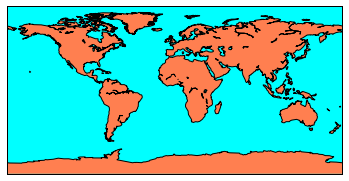

In [208]:
%matplotlib inline
import matplotlib
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import pyproj
from matplotlib.collections import PatchCollection

basemap = Basemap()

land_color = 'coral'
water_color = 'aqua'

basemap.drawmapboundary(fill_color=water_color)
basemap.fillcontinents(color=land_color, lake_color=water_color)
basemap.drawcoastlines()

The default value is `cyl`, or **Cylindrical Equidistant** projection, also known as Equirectangular projection or Plate Carrée

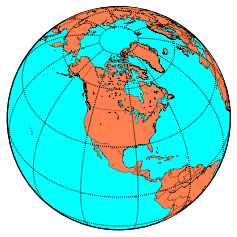

In [209]:
import numpy as np

basemap = Basemap(projection='ortho',lat_0=45,lon_0=-100,
                  resolution='l')

# draw coastlines, country boundaries, fill continents.
basemap.drawcoastlines(linewidth=0.25)
basemap.drawcountries(linewidth=0.25)
basemap.fillcontinents(color=land_color, lake_color=water_color)

# draw the edge of the map projection region (the projection limb)
basemap.drawmapboundary(fill_color=water_color)

# draw lat/lon grid lines every 30 degrees.
basemap.drawmeridians(np.arange(0,360,30))
basemap.drawparallels(np.arange(-90,90,30));

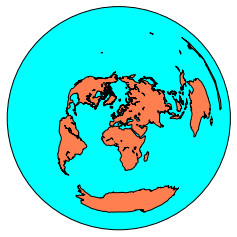

In [210]:
basemap = Basemap(projection='aeqd', lon_0 = 10, lat_0 = 50)

basemap.drawmapboundary(fill_color=water_color)
basemap.fillcontinents(color=land_color, lake_color=water_color)
basemap.drawcoastlines()

Restricting the map to a particlar region can be done by passing:

- a bounding box 
- the center of the map and the map size.

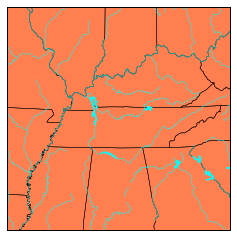

In [211]:
basemap_tn = Basemap(projection='aeqd', resolution='i',
              lon_0 = -86.8,
              lat_0 = 36.2,
              width = 1000000,
              height = 1000000)

basemap_tn.drawmapboundary(fill_color=land_color)
basemap_tn.drawstates(linewidth=0.45)
basemap_tn.drawrivers(color=water_color)
basemap_tn.drawcoastlines(color=water_color)

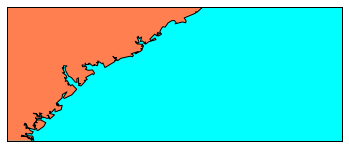

In [212]:
basemap_sc = Basemap(resolution='i',
    llcrnrlon=-81.5,
    llcrnrlat=31.6,
    urcrnrlon=-77.5,
    urcrnrlat=33.2,
    epsg='4326')

basemap_sc.drawmapboundary(fill_color=water_color)
basemap_sc.fillcontinents(color=land_color, lake_color=water_color)
basemap_sc.drawcoastlines()

### Cartopy

Cartopy is a Python package designed to make drawing maps for data analysis and visualisation easy.

It features:

- object oriented projection definitions
- point, line, polygon and image transformations between projections
- integration to expose advanced mapping in `matplotlib` with a simple and intuitive interface
- powerful vector data handling by integrating shapefile reading with `Shapely` capabilities

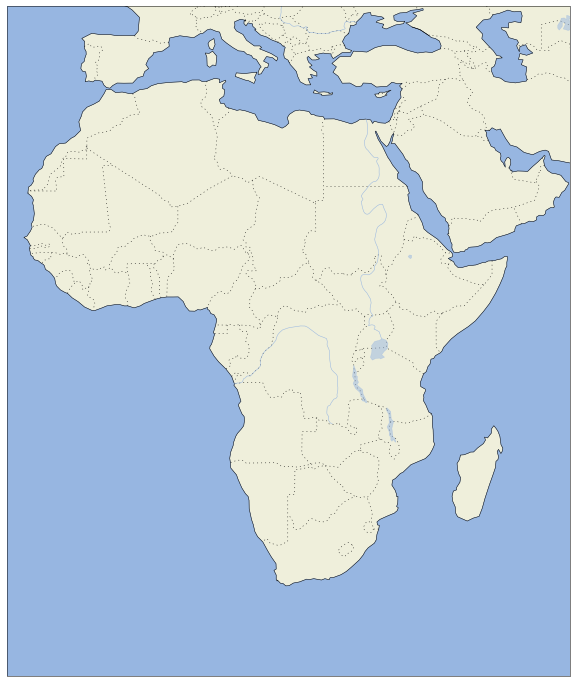

In [213]:
import pylab as plt
import cartopy
import warnings
warnings.filterwarnings('ignore') 

plt.figure(figsize=[18, 12])
ax = plt.axes(projection=cartopy.crs.PlateCarree()) 
ax.add_feature(cartopy.feature.LAND) 
ax.add_feature(cartopy.feature.OCEAN) 
ax.add_feature(cartopy.feature.COASTLINE) 
ax.add_feature(cartopy.feature.BORDERS, linestyle=':') 
ax.add_feature(cartopy.feature.LAKES, alpha=0.5) 
ax.add_feature(cartopy.feature.RIVERS) 
ax.set_extent([-20, 60, -40, 40]) 

## Geospatial data

There are two distinct types of geospatial data:

**Vector** data includes points, lines, polygons

**Raster** data includes images, digital elevation models, 2-D fields

For the purposes of our tutorial, we will restrict our attention to vector data.

### Reading and writing data

While you could in theory write your own parser to read a particular geo-spatial data format, it is much easier to use an existing Python library to do this. 

The most popular library for reading and writing geo-spatial data is the **Geospatial Data Abstraction Library** (GDAL/OGR). This is a very powerful library, as it supports [many data formats](http://www.gdal.org/ogr_formats.html).

However, the GDAL/OGR libraries are somewhat awkward to use directly in Python. A higher-level library called `Fiona` provides easy access to GDAL/OGR functionality.

### Manipulating data

There are often specific data manipulation tasks associated with analyzing geospatial data. This includes things like calculating intesections or unions, creating buffers around locations, calculating cnetroids or distances, and more. The GEOS (Geometry Engine - Open Source) library is the open-source standard for this, but like GDAL/OGR, the Python bindings are not very user-friendly. 

We will look at `Shapely` as a high-level alternative. It is based on GEOS, and is very fast.

### Simple example: Geocoding data

Let's try turning some simple coordinate data into a geographic format, and plotting it.

    city, lat, lon
    Charleston, 32.78, -79.93
    Savannah, 32.02, -81,12
    
We can read this data in using Pandas.

In [214]:
import pandas as pd

cities = pd.read_csv('cities.csv', index_col=0)
cities

,lat,lon
city,,
Charleston,32.78,-79.93
Savannah,32.02,-81.12


We can now use Shapely to convert these values to geographic features, namely Point features.

In [215]:
from shapely.geometry import Point

charleston = Point(cities.ix['Charleston'])
charleston.type

'Point'

In [217]:
dir(charleston)

['__and__',
 '__array_interface__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__geom__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__p__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 '__xor__',
 '_crs',
 '_ctypes_data',
 '_geom',
 '_get_coords',
 '_is_empty',
 '_lgeos',
 '_ndim',
 '_other_owned',
 '_repr_svg_',
 '_set_coords',
 'almost_equals',
 'area',
 'array_interface',
 'array_interface_base',
 'boundary',
 'bounds',
 'buffer',
 'centroid',
 'contains',
 'convex_hull',
 'coords',
 'crosses',
 'ctypes',
 'difference',
 'disjoint',
 'distance',
 'empty',
 'envelope',
 'equals',
 'equals_exact',
 'geom_type',
 'geometryType',
 'has_z',
 'impl',
 'interpolate',
 'intersection',
 'intersects',

Now we can use Fiona to write the data to a geospatial data format; we will use a shapefile.

In [218]:
from shapely.geometry import mapping
from fiona import collection

schema = { 'geometry': 'Point', 'properties': { 'name': 'str' } }
with collection("cities.shp", "w", "ESRI Shapefile", schema) as output:

        for city in cities.iterrows():
            name, coordinates = city
            point = Point(coordinates)
            output.write({
                'properties': {
                    'name': name
                },
                'geometry': mapping(point)
            })

Now we can import and plot our cities as we like.

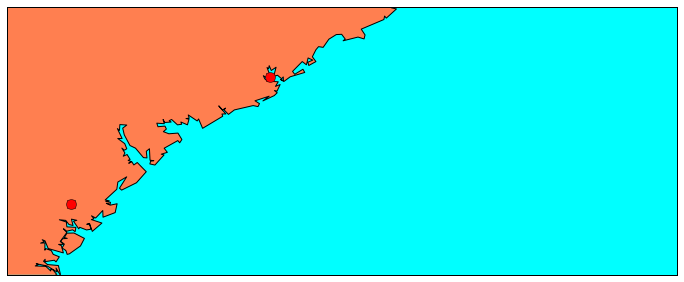

In [219]:
from shapely.geometry import MultiPoint, shape
import fiona
from fiona.crs import from_epsg

f, ax = plt.subplots(figsize=(12,6))
basemap_sc.drawmapboundary(fill_color=water_color)
basemap_sc.fillcontinents(color=land_color, lake_color=water_color)
basemap_sc.drawcoastlines()

mp = MultiPoint([shape(pol['geometry']) 
                 for pol in fiona.open('cities.shp')])

for polygon in mp:
    y, x = polygon.xy
    ax.plot(x, y, 'ro', markersize=10)


## GeoPandas

GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely.

For example, let's read in a file containing the boroughs of New York City:

In [220]:
boros = gpd.GeoDataFrame.from_file('nybb.shp')
boros.set_index('BoroCode', inplace=True)
boros.sort()
boros 

,BoroName,Shape_Area,Shape_Leng,geometry
BoroCode,,,,
5,Staten Island,1.623853e+09,330385.036974,(POLYGON ((970217.0223999023 145643.3322143555...
4,Queens,3.049947e+09,861038.479299,(POLYGON ((1029606.076599121 156073.8142089844...
3,Brooklyn,1.959432e+09,726568.946340,(POLYGON ((1021176.479003906 151374.7969970703...
1,Manhattan,6.364422e+08,358532.956418,(POLYGON ((981219.0557861328 188655.3157958984...
2,Bronx,1.186804e+09,464517.890553,(POLYGON ((1012821.805786133 229228.2645874023...


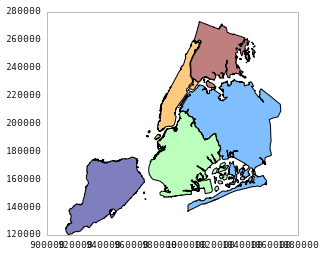

In [223]:
boros.plot()

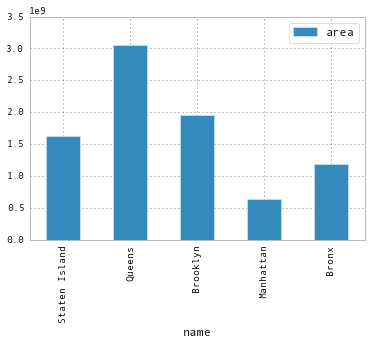

In [224]:
df = pd.DataFrame(index=boros.index, columns={})
df['area'] = boros.Shape_Area
df['name'] = boros.BoroName
df.index=df.name
df.plot(kind='bar')

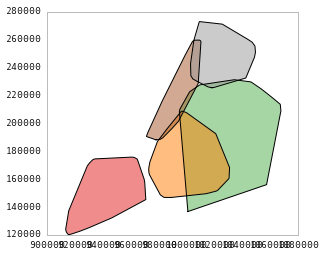

In [225]:
boros['geometry'].convex_hull.plot()

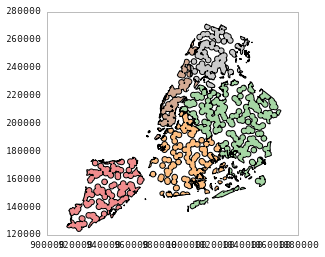

In [226]:
# generate a GeoSeries containing 2000 random points
xmin, xmax, ymin, ymax = 900000, 1080000, 120000, 280000
xc = (xmax - xmin) * np.random.random(2000) + xmin
yc = (ymax - ymin) * np.random.random(2000) + ymin
pts = gpd.GeoSeries([Point(x, y) for x, y in zip(xc, yc)])

# draw a circle with fixed radius around each point
circles = pts.buffer(2000)

# collapse these circles into a single shapely MultiPolygon geometry
mp = circles.unary_union

# extract the part of this geometry contained in each borough
holes = boros['geometry'].intersection(mp)
holes.plot()

We will use Geopandas to do a real risk analysis for an endangered marine mammal, the northern right whale.

In [227]:
import geopandas as gpd
from geopandas.tools import sjoin
from datetime import date

transits = gpd.GeoDataFrame.from_file('data/transits.shp').replace({-999: None})

In [228]:
transits.head()

,CALLSIGN,FLAG,FLAG_TYPE,IMO,LOA,MMSI,NAME,SOV,TR_END,TR_HRS,TR_NMS,TR_PERIOD,TR_RECS,TR_START,TYPE,geometry
0,A8KM7,Liberia (Republic of),Foreign,9344033,183,636013087,Tverskoy Bridge,N,2011-11-01 00:41:35+00,0.68,8.1,2011-2012,18,2011-11-01 00:00:35+00,Tanker,(LINESTRING (-79.37621699999994 32.66900000000...
1,A8OS2,Liberia (Republic of),Foreign,9353266,269,636013695,Ym Elixir,N,2011-11-01 01:07:24+00,1.11,14.6,2011-2012,37,2011-11-01 00:00:46+00,Cargo,(LINESTRING (-79.44591699999995 32.60640000000...
2,WSW6620,United States of America,Domestic,0,18,367061140,Savannah,N,2011-11-01 00:37:12+00,0.61,11.7,2011-2012,28,2011-11-01 00:00:52+00,Pilot,(LINESTRING (-80.78339299999993 31.99384500000...
3,VRGA7,Hong Kong (Special Administrative Region of Ch...,Foreign,9231810,293,477634700,Zim New York,N,2011-11-01 07:45:17+00,7.74,17.3,2011-2012,182,2011-11-01 00:01:10+00,Cargo,(LINESTRING (-79.56774999999993 32.64030000000...
4,None,United States of America,Domestic,0,19,338108309,Lucky Star,N,2011-11-02 11:39:31+00,35.64,3.0,2011-2012,1467,2011-11-01 00:01:12+00,Pleasure,(LINESTRING (-79.75942499999991 32.80539700000...


Import and project habitat model data

In [229]:
HabModelEnviro = gpd.GeoDataFrame.from_file('data/HabModelEnviro.shp').replace({-999: None})

In [230]:
HabModelEnviroWGS84 = HabModelEnviro.to_crs({'proj': 'longlat', 
                                             'ellps': 'WGS84', 
                                             'datum': 'WGS84'})

Truncate to area of interest (31o41' to 33o)

In [231]:
upper_limit = 33
lower_limit = 31.683

In [232]:
HabModelEnviroSC = HabModelEnviroWGS84[(lower_limit < HabModelEnviroWGS84.Lat) & 
                                       (HabModelEnviroWGS84.Lat < upper_limit)]

Import survey data and reproject to WGS84, then clip to area of interest.

In [234]:
HabModelSurvey = gpd.GeoDataFrame.from_file('data/HabModelSurvey.shp')
HabModelSurveyWGS84 = HabModelSurvey.to_crs({'proj': 'longlat', 
                                             'ellps': 'WGS84', 
                                             'datum': 'WGS84'})
HabModelSurveySC = HabModelSurveyWGS84[(lower_limit < HabModelSurveyWGS84.Lat) 
                                       & (HabModelSurveyWGS84.Lat < upper_limit)]

Perform a merge of survey and habitat data

In [235]:
# Use lower case for trailing A and B times
replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelEnviroSC.columns if c.endswith('A') or c.endswith('B')}
HabModelEnviro_points = HabModelEnviroSC.copy().rename(columns=replace_dict)
HabModelEnviro_points.geometry = HabModelEnviro_points.geometry.centroid

In [236]:
replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelSurveySC.columns if c.endswith('A') or c.endswith('B')}
HabModel_merged = sjoin(HabModelSurveySC.rename(columns=replace_dict), HabModelEnviro_points, how="left")

In [237]:
# Drop cells with null DistToShor values (land)
HabModel_merged = HabModel_merged.dropna(subset=['DistToShor'])

Buffer distance to shore

In [238]:
HabModel_merged = HabModel_merged[HabModel_merged.DistToShor>1000]

Convert data into long format and remove time information from column names. We are breaking the data into one table for each 2-week period.

In [239]:
time_intervals = ['Dec03a','Dec03b','Dec04a','Dec04b','Dec05a','Dec05b','Dec06a','Dec06b','Dec07a','Dec07b',
         'Dec08a','Dec08b','Dec09a','Dec09b','Dec10a','Dec10b','Dec11a','Dec11b','Dec12a','Dec12b',
         'Feb04a','Feb04b','Feb05a','Feb05b','Feb06a','Feb06b','Feb07a','Feb07b','Feb08a','Feb08b',
         'Feb09a','Feb09b','Feb10a','Feb10b','Feb11a','Feb11b','Feb12a','Feb12b','Feb13a','Feb13b',
         'Jan04a','Jan04b','Jan05a','Jan05b','Jan06a','Jan06b','Jan07a','Jan07b','Jan08a','Jan08b',
         'Jan09a','Jan09b','Jan10a','Jan10b','Jan11a','Jan11b','Jan12a','Jan12b','Jan13a','Jan13b',
         'Mar04a','Mar04b','Mar05a','Mar05b','Mar06a','Mar06b','Mar07a','Mar07b','Mar08a','Mar08b',
         'Mar09a','Mar09b','Mar10a','Mar10b','Mar11a','Mar11b','Mar12a','Mar12b','Mar13a','Mar13b']

data_types = ['Eff', 'Grps', 'Whls', 'iso', 'sst']

In [240]:
months = {'Dec':0, 'Jan':1, 'Feb':2, 'Mar':3}
fortnights = {'a':0, 'b':1}

Create unique cell ID

In [241]:
working_dataset = HabModel_merged.reset_index(level=0).rename(columns={'index':'quad_id'})

Create columns for 2-week period, year and time.

In [242]:
bimonthly_subsets = []
for t in time_intervals:
    # Build column name list
    cols = ['quad_id', 'geometry', 'DistToShor', 'MEAN_depth']
    n_fixed = len(cols)
    cols += [d+t for d in data_types[:-2]]
    cols += [d+t.lower() for d in data_types[-2:]]
    
    # Remove year time data from column labels
    subset = working_dataset[cols].rename(columns=dict(zip(cols[n_fixed:], data_types)))
    
    # Add time data
    month = months[t[:3]]
    year = int(t[3:-1])
    if not month:
        year +=1
    fortnight = fortnights[t[-1]]
    period = month*2 + fortnight
    
    subset['period'] = period
    subset['year'] = year - 3
    subset['time'] = t
    
    bimonthly_subsets.append(subset)

Concatenate subsets into single dataset

In [243]:
working_data_long = pd.concat(bimonthly_subsets, ignore_index=True)

Confirm that the resulting dataset is the same shape

In [244]:
assert sum([b.shape[0] for b in bimonthly_subsets]) == working_data_long.shape[0]

Extract shipping exposure data, primarily by filtering out ineligible transits (Dec-Mar only).

In [245]:
transits['start_time'] = pd.to_datetime(transits.TR_START, 'D')
transits = transits[transits.start_time.apply(lambda x: (x.month in (12, 1, 2, 3)) and (x.date()<date(2013, 4, 1)))]

In [246]:
transit_times = transits.start_time.astype(object)

In [247]:
month_lookup = {12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar'}

In [248]:
transits['time'] = transit_times.apply(lambda t: month_lookup[t.month] + str(t.year)[-2:] + ['a','b'][t.day>14])

Drop 2003, given the above, and recode year.

In [249]:
working_data_long['year'] = working_data_long.year - 1
working_data_long = working_data_long[working_data_long.year > 0]

In [250]:
working_data_long.head()

,quad_id,geometry,DistToShor,MEAN_depth,Eff,Grps,Whls,iso,sst,period,year,time
1210,4,"POLYGON ((-81.0638121503616 31.66385317360051,...",3863.834,-3.8095,15.846747,0,0,96621.078356,15.474,0,1,Dec04a
1211,5,POLYGON ((-81.00520442711309 31.66387073674769...,9203.932,-5.6428,9.329810,1,2,92330.602241,15.940,0,1,Dec04a
1212,6,POLYGON ((-80.94659696259843 31.66386003275813...,12499.129,-10.5952,11.931681,0,0,87950.966394,15.999,0,1,Dec04a
1213,7,"POLYGON ((-80.8879895953431 31.66382227576766,...",16670.382,-12.4523,23.011338,0,0,83711.069405,16.519,0,1,Dec04a
1214,8,POLYGON ((-80.82938237672916 31.66375760271118...,21411.103,-13.3809,23.367187,0,0,79633.234672,16.930,0,1,Dec04a


Intersect polygons with transits and count transit intersections with each polygon as metric of ship traffic. This is a computationally intensive task, so the result will be saved to a shapefile, to be reused in later sessions. Flip `import_data` to `False` to re-generate intersections.

In [251]:
import_data = True

if not import_data:
    working_data_long['traffic'] = None
    for t in time_intervals:
        lines = [shape(g) for g in transits[transits.time==t].geometry]
        working_data_long.loc[working_data_long.time==t, 'traffic'] = working_data_long[
            working_data_long.time==t].geometry.apply(lambda x: sum([shape(x).intersects(g) for g in lines]))

    gpd.GeoDataFrame(working_data_long).to_file('working_data_long.shp')

In [252]:
if import_data:
    working_data_long = gpd.GeoDataFrame.from_file('working_data_long.shp')

Vessel traffic maps for an arbitrary period

In [253]:
basemap_sc.proj4string

'+lon_0=-79.5 +units=m +a=6378137.0 +proj=eqc +b=6356752.314245179 '

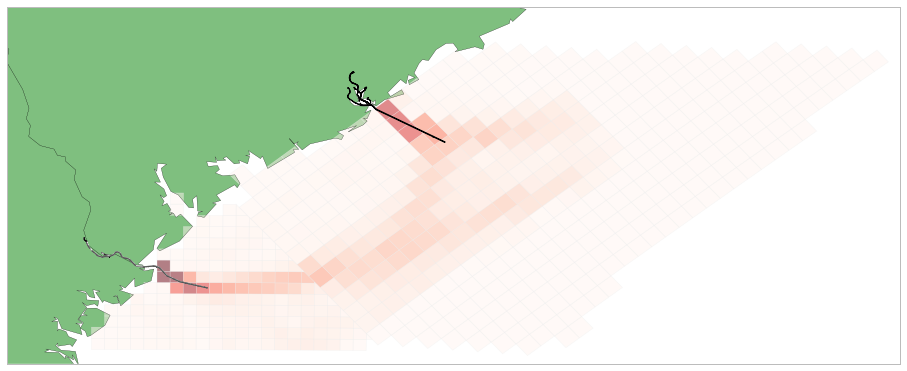

In [254]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

gpd.GeoDataFrame(working_data_long[working_data_long.time=='Jan13a']).plot(column='traffic', 
                                                                           colormap='Reds', linewidth=0, axes=ax)
reachesWGS84.plot(axes=ax, colormap='Greys')
navchannelWGS84.plot(axes=ax, colormap='Greys')

In [274]:
transits.head()

,CALLSIGN,FLAG,FLAG_TYPE,IMO,LOA,MMSI,NAME,SOV,TR_END,TR_HRS,TR_NMS,TR_PERIOD,TR_RECS,TR_START,TYPE,geometry,start_time,time
1419,3EQL7,Panama (Republic of),Foreign,9181675,294,354618000,Msc Sarah,N,2011-12-01 03:20:18+00,3.18,42.6,2011-2012,107,2011-12-01 00:09:29+00,Cargo,(LINESTRING (-79.85369199999991 32.74656000000...,2011-12-01 00:09:29,Dec11a
1420,LAOW5,Norway,Foreign,9191319,240,257613000,Talisman,N,2011-12-01 05:11:43+00,2.95,35.5,2011-2012,103,2011-12-01 02:14:33+00,Cargo,(LINESTRING (-80.84366499999993 32.03833300000...,2011-12-01 02:14:33,Dec11a
1421,WSW6620,United States of America,Domestic,0,18,367061140,Savannah,N,2011-12-01 03:47:57+00,1.52,25.4,2011-2012,55,2011-12-01 02:16:49+00,Pilot,(LINESTRING (-80.8343549999999 32.035468000000...,2011-12-01 02:16:49,Dec11a
1422,V7LY9,Marshall Islands (Republic of the),Foreign,9218337,186,538002825,Chios Legacy,N,2011-12-01 05:21:29+00,2.37,28.8,2011-2012,90,2011-12-01 02:59:01+00,Cargo,(LINESTRING (-80.83619999999991 32.03776700000...,2011-12-01 02:59:01,Dec11a
1423,WDF2357,United States of America,Domestic,0,17,367427760,Carolina,N,2011-12-01 08:44:53+00,5.70,41.7,2011-2012,78,2011-12-01 03:03:05+00,Pilot,(LINESTRING (-80.71335499999992 31.97947500000...,2011-12-01 03:03:05,Dec11a


In [255]:
dataset = working_data_long[~((working_data_long.Eff==0) & (working_data_long.Grps>0)) 
                            & working_data_long.sst.notnull() & working_data_long.MEAN_depth.notnull()]

# Include rows with positive effort
not_missing = dataset.Eff>0
dataset_surveyed = dataset[not_missing]
# Rows with zero effort is treated as missing data, to be predicted
missing_data = dataset[~not_missing]
centroids = dataset[['lat', 'lon']].values

This map shows relative mean survey effort in the region.

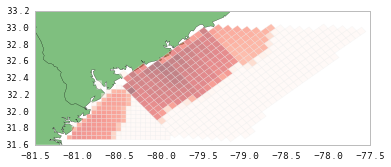

In [256]:
df_geo = dataset.groupby('quad_id')

test = dataset[(dataset.year==5) & (dataset.period==5)].copy()
test = test.set_index(test.quad_id)

test['total_groups'] = df_geo['Grps'].sum()
test['mean_effort'] = df_geo['Eff'].mean()

basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)
gpd.GeoDataFrame(test).plot(column='mean_effort', colormap='Reds', linewidth=0)

## Conditional autoregressive model of whale occurrence

One of the key features of this analysis is the modeling of spatial autocorrelation via Gaussian processes. Since the number of surveys and sightings are limited, we need to borrow strength among the grid cells of the region, recognizing that an animal observed in one cell is likely to also be in neighboring cells within the same period. The Gaussian process models the spatial covariance directly, here estimating a risk surface of whale occurrence.

In [257]:
from pymc import Normal, Exponential, Uniform, Uninformative, Bernoulli, Poisson, Gamma
from pymc import Lambda, MCMC, invlogit, AdaptiveMetropolis, MCMC, normal_like
from pymc import potential, deterministic, stochastic, rnormal

Create mesh of area from grid centroids.

In [258]:
latmin, lonmin = centroids.min(0)
latmax, lonmax = centroids.max(0)
grid = np.meshgrid(np.linspace(lonmin, lonmax), np.linspace(latmin, latmax))
geo_mesh = np.vstack((np.ravel(grid[0]), np.ravel(grid[1]))).T*np.pi/180.

Extract columns of interest from dataset.

In [259]:
(lat, lon, period, year, sst, iso, traffic, depth) = dataset[
    ['lat', 'lon', 'period', 'year', 'sst', 'iso', 'traffic', 'MEAN_depth']].values.T
period = period.astype(int)

Use grouped dataset to extract summary values for each polygon

In [260]:
df_geo = dataset.groupby('quad_id')

In [261]:
# Columns that need to be averaged
data_summarized = df_geo[['lat', 'lon', 'sst', 'iso', 'MEAN_depth']].mean()
# Columns that need to be summed
data_summarized[['traffic', 'Grps', 'Whls', 'Eff']] = df_geo[['traffic', 'Grps', 'Whls', 'Eff']].sum()
data_summarized['geometry'] = df_geo['geometry'].first()
data_summarized.head()

,lat,lon,sst,iso,MEAN_depth,traffic,Grps,Whls,Eff,geometry
quad_id,,,,,,,,,,
4,-81.093142,31.688897,13.256247,119200.031023,-3.8095,4,0,0,1870.059657,"POLYGON ((-81.0638121503616 31.66385317360051,..."
5,-81.034518,31.688928,13.469918,114477.800710,-5.6428,13,1,2,2388.797729,POLYGON ((-81.00520442711309 31.66387073674769...
6,-80.975895,31.688932,13.618718,109732.472247,-10.5952,25,0,0,2389.803678,POLYGON ((-80.94659696259843 31.66386003275813...
7,-80.917272,31.688908,13.738225,104984.253630,-12.4523,33,2,3,2350.584436,"POLYGON ((-80.8879895953431 31.66382227576766,..."
8,-80.858649,31.688856,13.886081,100228.491291,-13.3809,40,1,1,2304.253170,POLYGON ((-80.82938237672916 31.66375760271118...


Confirm no missing values

In [262]:
data_summarized.isnull().sum()

lat           0
lon           0
sst           0
iso           0
MEAN_depth    0
traffic       0
Grps          0
Whls          0
Eff           0
geometry      0
dtype: int64

Remove unsurveyed polygons

In [263]:
data_surveyed = data_summarized[data_summarized.Eff>0]

Normalize SST, ISO and depth

In [264]:
normalize = lambda x: np.array((x - x.mean()) / x.std())

In [265]:
sst_norm = normalize(data_surveyed.sst)
iso_norm = normalize(data_surveyed.iso)
depth_norm = normalize(data_surveyed.MEAN_depth)

In [266]:
traffic = data_surveyed.traffic.values

In [267]:
groups, whales, effort = data_surveyed[['Grps', 'Whls', 'Eff']].values.T
year = year.astype(int)
groups = groups.astype(int)

Scale effort by a factor of 100 to avoid numerical issues

In [268]:
effort = effort/100.

Generate neighborhood matrix for all polygons, to be used in the first-order conditional autoregressive model.

In [269]:
data_gdf = gpd.GeoDataFrame(data_surveyed)

In [270]:
neighbors = np.array([data_gdf.geometry.touches(v).values for i, v in data_gdf.geometry.iteritems()])

We will be using a Gaussian radial basis function for the non-parametric regression terms describing the effects of isobath and depth on whale probability.

In [271]:
gaussian_rbf = lambda x, mu, l: np.exp(-np.abs(x - mu)**2 / l**2)

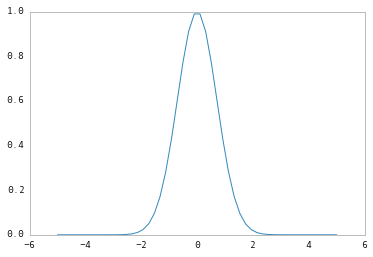

In [272]:
xrange = np.linspace(-5, 5)
plt.plot(xrange, [gaussian_rbf(x, 0, 1) for x in xrange])

### Non-parametric regression sub-model

In order to avoid making assumptions about the functional form of the relationship between spatial covariates (water depth and distance to 22-degree isotherm) and the encounter rate with whale groups. For each variable, we specify ten Student-t distributed basis functions that are evenly-spaced over the observed range of the variables. The parameters corresponding to each basis function are then weighted according to the distance from a given point to the center of the function, and added to form a coefficient. The result is a flexible, non-parametric function.

In [273]:
def rbf(name, x, n=10):
    
    # Number of basis functions for isobath effect
    h = np.linspace(x.min(), x.max(), 10)
    l = Exponential('l_%s' % name, 1, value=1)
    # RBF weights
    w = Lambda('w_%s' % name, lambda l=l: np.array([gaussian_rbf(i, h, l) for i in x]))
    
    σ = Gamma('σ_%s' % name, 0.5, 0.5, value=np.ones(n))
    τ = σ**-2

    β = Normal('β_%s' % name, 0, τ, value=np.zeros(n))
    τ_rbf = Exponential('τ_rbf_%s' % name, 1, value=1)
    
    @stochastic(name='rbf_%s' % name)
    def rbf(value=np.zeros(len(groups)), β=β, w=w, τ=τ_rbf):
        m = w.dot(β)
        return normal_like(value, m, τ)
    
    @deterministic(name='rbf_eval_%s' % name)
    def rbf_eval(β=β, τ=τ_rbf, l=l):
        wts = np.array([gaussian_rbf(i, h, l) for i in h])
        m = wts.dot(β)
        return rnormal(m, τ)
    
    return locals()

### Conditional autoregressive (CAR) model

In order to allow for the spatial autocorrelation of whale group observations, we implemented a first-order conditional autoregressive model, which expresses the effect in the current cell $k$ as a Gaussian-distributed random variable, with a mean equal to the weighted average of the direct neighbors (typically 8 cells). 

![CAR](http://d.pr/i/11AkN+)

Here, we equally weight all neighbors, $w_{ki} = 1 \, \forall \, i,k$.

In [ ]:
def rbf_car_model():
    
    intercept = Normal('intercept', 0, 0.001, value=0)
    
    rbf_iso = rbf('iso', iso_norm)
    
    rbf_depth = rbf('depth', depth_norm)
    
    # CAR component
    ϕ = Uninformative('ϕ', value=np.zeros(len(groups)))
    τ_car = Exponential('τ_car', 1, value=1)
    
    @potential
    def car(ϕ=ϕ, τ=τ_car):
        
        n = neighbors.sum(0).astype(float)
        
        return normal_like(ϕ, ϕ.dot(neighbors)/n, n*τ)

    # Occurrence rate
    @deterministic
    def θ(β0=intercept, β1=rbf_depth['rbf'], β2=rbf_iso['rbf'], phi=ϕ):
        return np.exp(β0 + β1 + β2 + phi) 

    λ = Lambda('λ', lambda θ=θ: θ * effort)
        
    # Likelihood
    group_obs = Poisson('group_obs', λ, value=groups, observed=True)
    
    risk = Lambda('risk', lambda theta=θ: theta*traffic)
               
    return locals()

Instantiate and run MCMC model

In [183]:
M = MCMC(rbf_car_model())

# Use adaptive Metropolis to improve mixing for some variables
M.use_step_method(AdaptiveMetropolis, M.__dict__['rbf_iso']['σ'])
M.use_step_method(AdaptiveMetropolis, M.__dict__['rbf_depth']['σ'])
M.use_step_method(AdaptiveMetropolis, M.ϕ)

In [184]:
M.sample(20000, 19000)

 [-----------------100%-----------------] 20000 of 20000 complete in 129.0 sec

## Model output

The following graphical summaries show the posterior distribution of key parameters.


Basis function variances for isobath effect

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


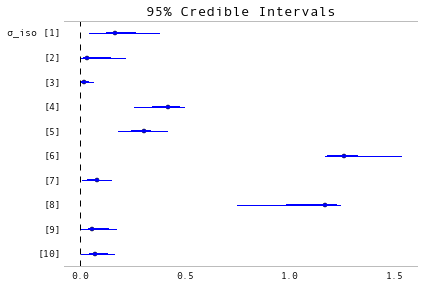

In [185]:
from pymc import Matplot

Matplot.summary_plot(M.__dict__['rbf_iso']['σ'])

Plotting τ_rbf_iso


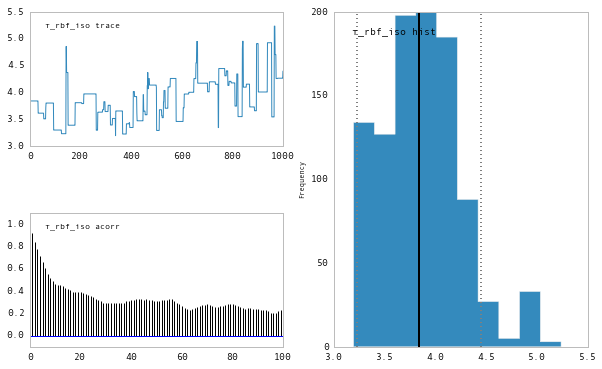

In [186]:
Matplot.plot(M.__dict__['rbf_iso']['τ_rbf'])

Plotting intercept


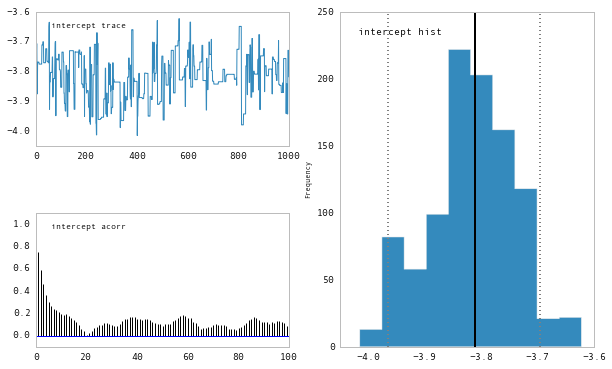

In [187]:
Matplot.plot(M.intercept)

Non-parametric depth effect (recall that depth is expressed in negative values in the dataset)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


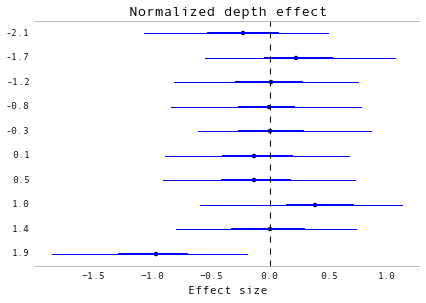

In [188]:
Matplot.summary_plot(M.__dict__['rbf_depth']['rbf_eval'], 
                     custom_labels=np.linspace(iso_norm.min(), iso_norm.max(), 10).round(1).astype(str),
                    xlab='Effect size', main='Normalized depth effect')

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


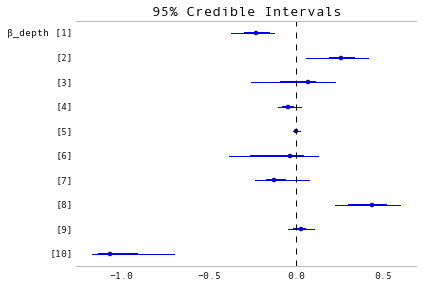

In [189]:
Matplot.summary_plot(M.__dict__['rbf_depth']['β'])

Non-parametric isotherm effect:

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


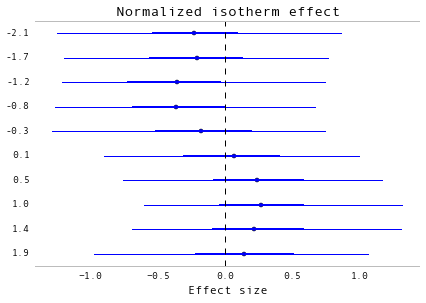

In [190]:
Matplot.summary_plot(M.__dict__['rbf_iso']['rbf_eval'],
                     custom_labels=np.linspace(iso_norm.min(), iso_norm.max(), 10).round(1).astype(str),
                    xlab='Effect size', main='Normalized isotherm effect')

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


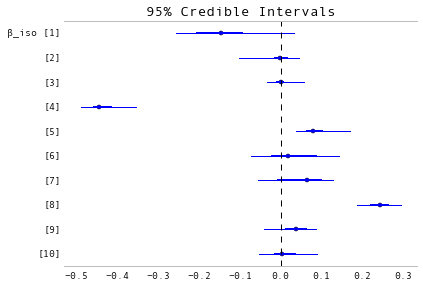

In [191]:
Matplot.summary_plot(M.__dict__['rbf_iso']['β'])

In [192]:
data_surveyed['p_pred'] = M.θ.stats()['mean']

In [197]:
def plot_series(series, data=data_surveyed, cmap='Reds'):
    
    gdf = gpd.GeoDataFrame(data)
    
    fig = plt.figure(figsize=(16,12))
    ax = plt.gca()
    basemap_sc.drawstates(linewidth=0.15)
    basemap_sc.drawcoastlines(linewidth=0.25)
    basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)
    gdf.plot(column=series, colormap=cmap, linewidth=0, axes=ax)


Expected encounter rate

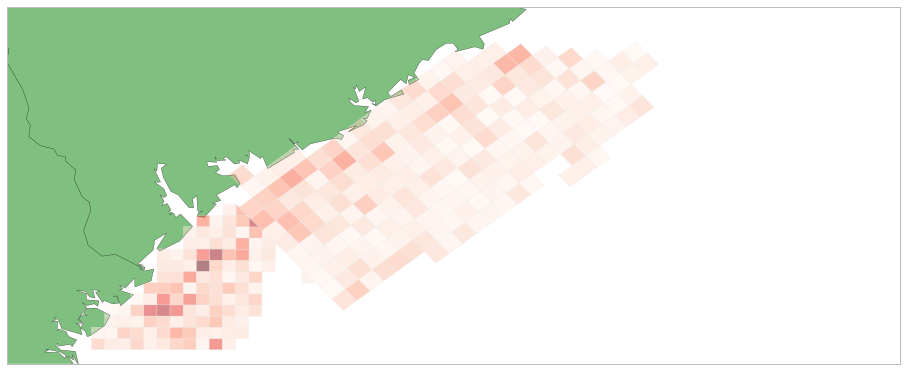

In [198]:
plot_series('p_pred')

Estimate of risk based on past traffic

In [199]:
data_surveyed['risk'] = M.risk.stats()['mean']

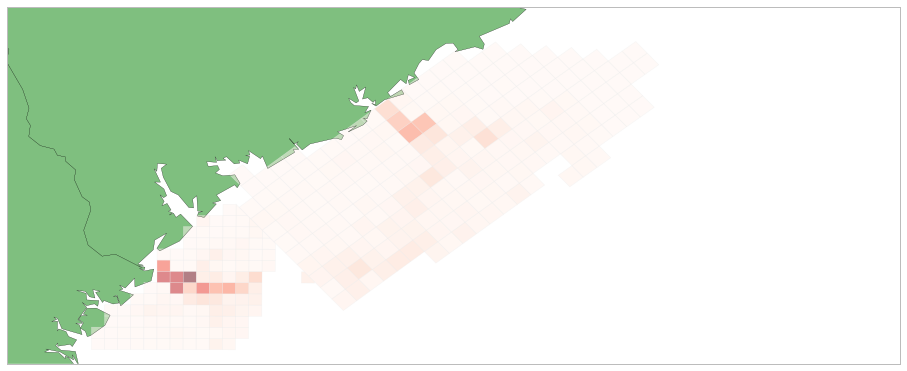

In [200]:
plot_series('risk')

Spatial autocorrelation effect

In [201]:
data_surveyed['phi'] = M.ϕ.stats()['mean']

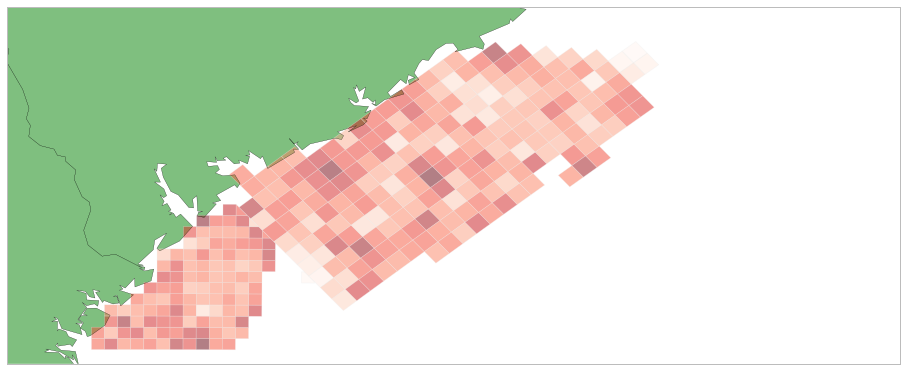

In [202]:
plot_series('phi')

Traffic on the logarithmic scale

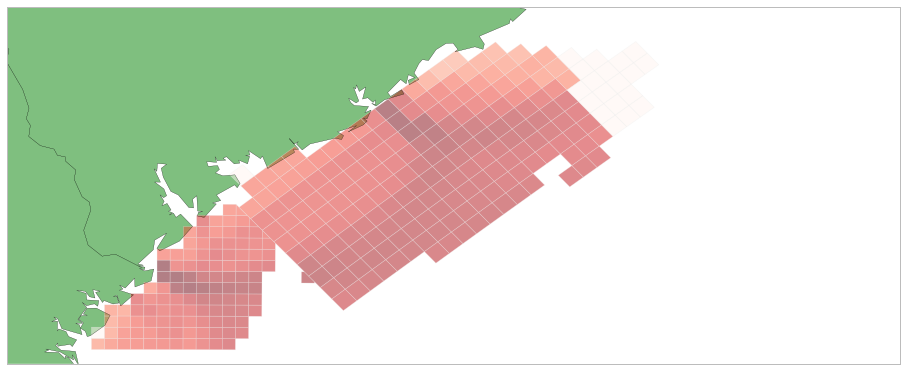

In [203]:
data_surveyed['log_traffic'] = np.log(data_surveyed.traffic + 0.01)

plot_series('log_traffic')

---

In [204]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()